Hypothesis: Stocks follow a random walk. The price movement of a stock today has no statistically significant predicitve power in determing its price tomorrow

In [1]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics, linear_model, datasets, feature_selection
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, roc_curve

Tesla Stock Analysis

In [2]:
tesla = pd.read_csv('TSLA.csv')

In [3]:
tesla.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2416.000000,2416.000000,2416.000000,2416.000000,2416.000000,2.416000e+03
mean,186.271147,189.578224,182.916639,186.403651,186.403651,5.572722e+06
std,118.740163,120.892329,116.857591,119.136020,119.136020,4.987809e+06
min,16.139999,16.629999,14.980000,15.800000,15.800000,1.185000e+05
25%,34.342498,34.897501,33.587501,34.400002,34.400002,1.899275e+06
50%,213.035003,216.745002,208.870002,212.960007,212.960007,4.578400e+06
75%,266.450012,270.927513,262.102501,266.774994,266.774994,7.361150e+06
max,673.690002,786.140015,673.520020,780.000000,780.000000,4.706500e+07


In [4]:
tesla.head(5) #showing first 5 rows of the original database

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [5]:
tesla.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [6]:
tesla['Percentage change in price'] = (tesla['Close']/tesla['Close'].shift(1))-1 #Change in price "today" = price today - price yesterday, shift notation is inversed
#-1 is tomorrow, 1 is yesterday

In [7]:
tesla.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,Percentage change in price
0,2010-06-29,19.000000,25.000000,17.540001,23.889999,23.889999,18766300,NaN
1,2010-06-30,25.790001,30.420000,23.299999,23.830000,23.830000,17187100,-0.002511
2,2010-07-01,25.000000,25.920000,20.270000,21.959999,21.959999,8218800,-0.078473
3,2010-07-02,23.000000,23.100000,18.709999,19.200001,19.200001,5139800,-0.125683
4,2010-07-06,20.000000,20.000000,15.830000,16.110001,16.110001,6866900,-0.160937
5,2010-07-07,16.400000,16.629999,14.980000,15.800000,15.800000,6921700,-0.019243
6,2010-07-08,16.139999,17.520000,15.570000,17.459999,17.459999,7711400,0.105063
7,2010-07-09,17.580000,17.900000,16.549999,17.400000,17.400000,4050600,-0.003436
8,2010-07-12,17.950001,18.070000,17.000000,17.049999,17.049999,2202500,-0.020115
9,2010-07-13,17.389999,18.639999,16.900000,18.139999,18.139999,2680100,0.063930


In [8]:
tesla['Percentage change in price'].describe()

count    2415.000000
mean        0.001975
std         0.032762
min        -0.193274
25%        -0.014178
50%         0.000870
75%         0.018115
max         0.243951
Name: Percentage change in price, dtype: float64

In [9]:
tesla_auto_corr = pd.Series(tesla['Percentage change in price'])

In [10]:
print(f'Autocorrelation in percentage price change 1 day lag: {tesla_auto_corr.autocorr(lag=1)}') 
print(f'Autocorrelation in percentage price change 10 day lag: {tesla_auto_corr.autocorr(lag=10)}') 
print(f'Autocorrelation in percentage price change 30 day lag: {tesla_auto_corr.autocorr(lag=30)}') 
print(f'Autocorrelation in percentage price change 90 day lag: {tesla_auto_corr.autocorr(lag=90)}') 

Autocorrelation in percentage price change 1 day lag: 0.008628711791364287
Autocorrelation in percentage price change 10 day lag: 0.014093612910607414
Autocorrelation in percentage price change 30 day lag: 0.014708342742235087
Autocorrelation in percentage price change 90 day lag: 0.0018570185923042605


In [11]:
tesla['tesla_1_day_autocorr'] = tesla_auto_corr.autocorr(lag=1) #autocorrelation todays price change with yesterdays
tesla['tesla_10_day_autocorr'] = tesla_auto_corr.autocorr(lag=10) #autocorrelation todays price change with price 10 days ago
tesla['tesla_30_day_autocorr'] = tesla_auto_corr.autocorr(lag=30) #30 days ago
tesla['Tesla_90_day_autocorr'] = tesla_auto_corr.autocorr(lag=90) #90 days ago

In [12]:
tesla['1_day_close'] = tesla['Close'].shift(-1) #price 1 day in the future from "today"

In [13]:
tesla['Price Up Tomorrow'] = np.where(tesla['Close'].shift(-1)>tesla['Close'], 1, 0) #Price Up Tomorrow Tomorrow is True (1) if tomorrows 
#closing price is higher than todays. This will be our dependent variable we are trying to predict for our classficiation model

In [14]:
tesla.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416 entries, 0 to 2415
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        2416 non-null   object 
 1   Open                        2416 non-null   float64
 2   High                        2416 non-null   float64
 3   Low                         2416 non-null   float64
 4   Close                       2416 non-null   float64
 5   Adj Close                   2416 non-null   float64
 6   Volume                      2416 non-null   int64  
 7   Percentage change in price  2415 non-null   float64
 8   tesla_1_day_autocorr        2416 non-null   float64
 9   tesla_10_day_autocorr       2416 non-null   float64
 10  tesla_30_day_autocorr       2416 non-null   float64
 11  Tesla_90_day_autocorr       2416 non-null   float64
 12  1_day_close                 2415 non-null   float64
 13  Price Up Tomorrow           2416 

In [15]:
tesla.dropna(axis=0, inplace=True)

In [16]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [17]:
TRAIN_SPLIT = 1743 #represents a 75% training split

In [18]:
tf.random.set_seed(13)

In [19]:
uni_data = tesla[['Percentage change in price']]
uni_data.index = tesla['Date']
uni_data.head(10)

,Percentage change in price
Date,
2010-06-30,-0.002511
2010-07-01,-0.078473
2010-07-02,-0.125683
2010-07-06,-0.160937
2010-07-07,-0.019243
2010-07-08,0.105063
2010-07-09,-0.003436
2010-07-12,-0.020115
2010-07-13,0.063930


Text(0.5, 1.0, 'Tesla 1 Day Price Movement')

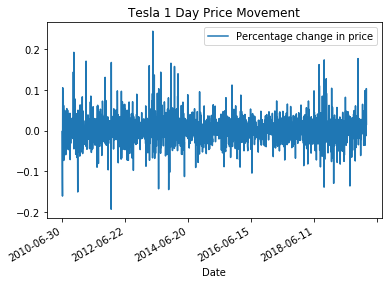

In [20]:
uni_data.plot(subplots=True)
plt.title('Tesla 1 Day Price Movement')

In [21]:
uni_data = uni_data.values

In [22]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [23]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [24]:
univariate_past_history = 30
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [25]:
def create_time_steps(length):
  return list(range(-length, 0))

In [26]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'bo', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

In [27]:
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(1743).batch(32).repeat()

tesla_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
tesla_univariate = tesla_univariate.batch(32).repeat()

In [28]:
tesla_lstm_model = tf.keras.models.Sequential([tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),tf.keras.layers.Dense(1)])
tesla_lstm_model.add(tf.keras.layers.Dropout(0.2))
tesla_lstm_model.add(tf.keras.layers.Activation('linear'))
tesla_lstm_model.compile(optimizer='adam', loss='mape')

In [29]:
tesla_lstm_model.fit(train_univariate, epochs=10,
                      steps_per_epoch=500,
                      validation_data=tesla_univariate, validation_steps=50)

Epoch 1/10
500/500 [==============================] - 4s 9ms/step - loss: 102.4680 - val_loss: 100.7040
Epoch 2/10
500/500 [==============================] - 4s 8ms/step - loss: 101.0587 - val_loss: 100.6099
Epoch 3/10
500/500 [==============================] - 4s 8ms/step - loss: 100.8313 - val_loss: 100.0208
Epoch 4/10
500/500 [==============================] - 4s 8ms/step - loss: 100.7865 - val_loss: 100.2818
Epoch 5/10
500/500 [==============================] - 4s 8ms/step - loss: 100.3983 - val_loss: 101.8316
Epoch 6/10
500/500 [==============================] - 4s 9ms/step - loss: 100.3061 - val_loss: 99.8783
Epoch 7/10
500/500 [==============================] - 4s 8ms/step - loss: 100.3772 - val_loss: 100.7122
Epoch 8/10
500/500 [==============================] - 4s 9ms/step - loss: 100.4818 - val_loss: 99.7487
Epoch 9/10
500/500 [==============================] - 4s 9ms/step - loss: 100.1368 - val_loss: 99.6494
Epoch 10/10
500/500 [==============================] - 5s 9ms/step 

In [30]:
def model_mape(model):
    mape = []
    for i in model.history.history['val_loss']:
        mape.append(i)
    return sum(mape)/(len(model.history.history['val_loss']))

In [31]:
print(f'Tesla dataset MAPE: {model_mape(tesla_lstm_model)}')

Tesla dataset MAPE: 100.36364517211913


In [32]:
def prediction_attempt(model, model_name, data):
    for x, y in data.take(3):
      plot = show_plot([x[0].numpy(), y[0].numpy(), model.predict(x_val_uni)[0]],1, model_name)
      
      plot.show()

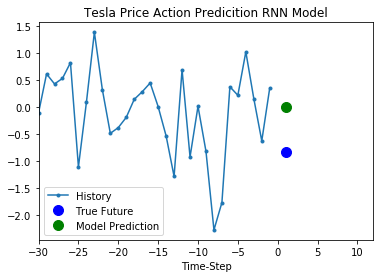

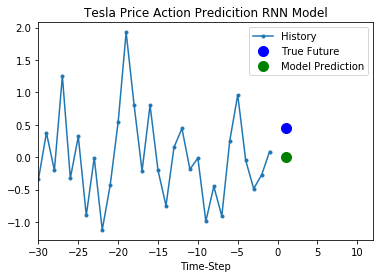

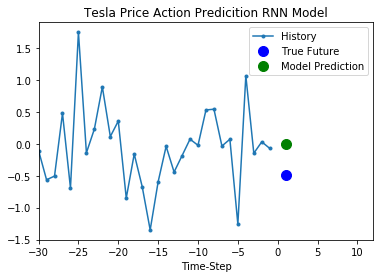

In [33]:
prediction_attempt(tesla_lstm_model, 'Tesla Price Action Predicition RNN Model', tesla_univariate)

In [34]:
tesla.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,Percentage change in price,tesla_1_day_autocorr,tesla_10_day_autocorr,tesla_30_day_autocorr,Tesla_90_day_autocorr,1_day_close,Price Up Tomorrow
1,2010-06-30,25.790001,30.420000,23.299999,23.830000,23.830000,17187100,-0.002511,0.008629,0.014094,0.014708,0.001857,21.959999,0
2,2010-07-01,25.000000,25.920000,20.270000,21.959999,21.959999,8218800,-0.078473,0.008629,0.014094,0.014708,0.001857,19.200001,0
3,2010-07-02,23.000000,23.100000,18.709999,19.200001,19.200001,5139800,-0.125683,0.008629,0.014094,0.014708,0.001857,16.110001,0
4,2010-07-06,20.000000,20.000000,15.830000,16.110001,16.110001,6866900,-0.160937,0.008629,0.014094,0.014708,0.001857,15.800000,0
5,2010-07-07,16.400000,16.629999,14.980000,15.800000,15.800000,6921700,-0.019243,0.008629,0.014094,0.014708,0.001857,17.459999,1
6,2010-07-08,16.139999,17.520000,15.570000,17.459999,17.459999,7711400,0.105063,0.008629,0.014094,0.014708,0.001857,17.400000,0
7,2010-07-09,17.580000,17.900000,16.549999,17.400000,17.400000,4050600,-0.003436,0.008629,0.014094,0.014708,0.001857,17.049999,0
8,2010-07-12,17.950001,18.070000,17.000000,17.049999,17.049999,2202500,-0.020115,0.008629,0.014094,0.014708,0.001857,18.139999,1
9,2010-07-13,17.389999,18.639999,16.900000,18.139999,18.139999,2680100,0.063930,0.008629,0.014094,0.014708,0.001857,19.840000,1
10,2010-07-14,17.940001,20.150000,17.760000,19.840000,19.840000,4195200,0.093716,0.008629,0.014094,0.014708,0.001857,19.889999,1


In [35]:
x = tesla[['Open', 'High','Low','Close', 'Volume']]
y = tesla['Price Up Tomorrow']

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.75, shuffle=True)

In [36]:
(tesla['Price Up Tomorrow']==1).describe()

count     2414
unique       2
top       True
freq      1235
Name: Price Up Tomorrow, dtype: object

In [43]:
scaler = StandardScaler()  # standardize our variables
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [44]:
neural_model = MLPClassifier(solver='adam', alpha=0.0001, hidden_layer_sizes=(5,2)) 

In [45]:
neural_model.fit(x_train, y_train)
print(f'Model accuracy: {neural_model.score(x_train, y_train)}')

Model accuracy: 0.5016574585635359


In [46]:
neural_predict = neural_model.predict(x_test)

In [47]:
print(f'neural network model accuracy is: {neural_model.score(x_train, y_train)}')
print(f'neural network f1 score is: {f1_score(y_test, neural_predict)}')
print(f'neural network precision is: {precision_score(y_test, neural_predict)}')
print(f'neural network recall is: {recall_score(y_test, neural_predict)}')

neural network model accuracy is: 0.5016574585635359
neural network f1 score is: 0.5391566265060241
neural network precision is: 0.5264705882352941
neural network recall is: 0.5524691358024691


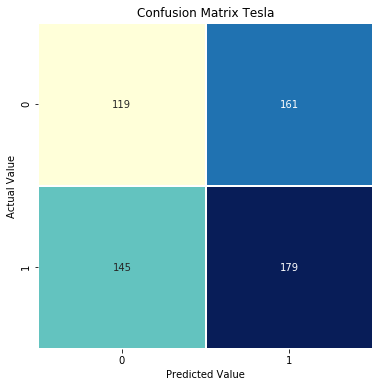

In [48]:
neural_matrix = confusion_matrix(y_test,neural_predict)
plt.subplots(figsize=(6, 6))
sns.heatmap(neural_matrix, annot=True, cbar=False, cmap='YlGnBu',linewidth=1,fmt="d")
plt.ylabel('Actual Value')
plt.xlabel('Predicted Value')
plt.title('Confusion Matrix Tesla');

#1 = Price Up Tomorrow, 0 = Price Down Tomorrow

Tesla analysis does not provide any evidence to reject the null hypothesis


AMD Stock Analysis

In [29]:
amd = pd.read_csv('AMD.csv')

In [30]:
amd.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2.335000e+03
mean,6.434732,6.563961,6.300887,6.433221,6.433221,3.107491e+07
std,3.872391,3.954999,3.792914,3.879124,3.879124,2.791149e+07
min,1.620000,1.690000,1.610000,1.620000,1.620000,0.000000e+00
25%,3.480000,3.550000,3.405000,3.465000,3.465000,1.421670e+07
50%,5.580000,5.720000,5.450000,5.600000,5.600000,2.228020e+07
75%,8.555000,8.710000,8.375000,8.565000,8.565000,3.776905e+07
max,25.510000,27.299999,24.629999,25.260000,25.260000,3.250584e+08


In [31]:
amd.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-05-22,4.43,4.43,4.25,4.26,4.26,8274300
1,2009-05-26,4.26,4.57,4.23,4.53,4.53,16094300
2,2009-05-27,4.57,4.80,4.55,4.71,4.71,21512600
3,2009-05-28,4.75,4.84,4.54,4.70,4.70,18383900
4,2009-05-29,4.71,4.78,4.38,4.54,4.54,24539700


In [32]:
amd.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [33]:
amd.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-05-22,4.43,4.43,4.25,4.26,4.26,8274300
1,2009-05-26,4.26,4.57,4.23,4.53,4.53,16094300
2,2009-05-27,4.57,4.80,4.55,4.71,4.71,21512600
3,2009-05-28,4.75,4.84,4.54,4.70,4.70,18383900
4,2009-05-29,4.71,4.78,4.38,4.54,4.54,24539700
5,2009-06-01,4.69,4.90,4.64,4.73,4.73,26633200
6,2009-06-02,4.68,4.70,4.55,4.56,4.56,24950700
7,2009-06-03,4.55,4.60,4.34,4.48,4.48,19087100
8,2009-06-04,4.57,4.74,4.54,4.65,4.65,19728300
9,2009-06-05,4.84,4.87,4.61,4.63,4.63,18775200


In [34]:
amd['Percentage change in price'] = (amd['Close']/amd['Close'].shift(1))-1

In [35]:
amd['Percentage change in price'].describe()

count    2334.000000
mean        0.001393
std         0.035922
min        -0.242291
25%        -0.016622
50%         0.000000
75%         0.018172
max         0.522901
Name: Percentage change in price, dtype: float64

In [36]:
amd_auto_corr = pd.Series(amd['Percentage change in price'])

In [37]:
print(f'Amd autocorrelation for percent change in price at 1 day lag: {amd_auto_corr.autocorr(lag=1)}')
print(f'Amd autocorrelation for percent change in price at 10 day lag: {amd_auto_corr.autocorr(lag=10)}')
print(f'Amd autocorrelation for percent change in price at 30 day lag: {amd_auto_corr.autocorr(lag=30)}')
print(f'Amd autocorrelation for percent change in price at 90 day lag: {amd_auto_corr.autocorr(lag=90)}')

Amd autocorrelation for percent change in price at 1 day lag: 0.004431876351059422
Amd autocorrelation for percent change in price at 10 day lag: 0.04945694510526541
Amd autocorrelation for percent change in price at 30 day lag: -0.024917746546279724
Amd autocorrelation for percent change in price at 90 day lag: -0.02975236121221433


In [38]:
amd['amd_1_day_autocorr'] = amd_auto_corr.autocorr(lag=1)
amd['amd_10_day_autocorr'] = amd_auto_corr.autocorr(lag=10)
amd['amd_30_day_autocorr'] = amd_auto_corr.autocorr(lag=30)
amd['amd_90_day_autocorr'] = amd_auto_corr.autocorr(lag=90)

In [39]:
amd['1_day_close'] = amd['Close'].shift(-1)

In [40]:
amd['Price Up Tomorrow'] = np.where(amd['Close'].shift(-1)>amd['Close'], 1, 0) #Price Up Tomorrow tomorrow is True (1) if tomorrows 
#closing price is higher than todays. This will be our dependent variable we are trying to predict for our classficiation model

In [41]:
amd.dropna(axis=0, inplace=True)

In [42]:
amd.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Percentage change in price,amd_1_day_autocorr,amd_10_day_autocorr,amd_30_day_autocorr,amd_90_day_autocorr,1_day_close,Price Up Tomorrow
1,2009-05-26,4.26,4.57,4.23,4.53,4.53,16094300,0.063380,0.004432,0.049457,-0.024918,-0.029752,4.71,1
2,2009-05-27,4.57,4.80,4.55,4.71,4.71,21512600,0.039735,0.004432,0.049457,-0.024918,-0.029752,4.70,0
3,2009-05-28,4.75,4.84,4.54,4.70,4.70,18383900,-0.002123,0.004432,0.049457,-0.024918,-0.029752,4.54,0
4,2009-05-29,4.71,4.78,4.38,4.54,4.54,24539700,-0.034043,0.004432,0.049457,-0.024918,-0.029752,4.73,1
5,2009-06-01,4.69,4.90,4.64,4.73,4.73,26633200,0.041850,0.004432,0.049457,-0.024918,-0.029752,4.56,0


In [43]:
amd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2333 entries, 1 to 2333
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        2333 non-null   object 
 1   Open                        2333 non-null   float64
 2   High                        2333 non-null   float64
 3   Low                         2333 non-null   float64
 4   Close                       2333 non-null   float64
 5   Adj Close                   2333 non-null   float64
 6   Volume                      2333 non-null   int64  
 7   Percentage change in price  2333 non-null   float64
 8   amd_1_day_autocorr          2333 non-null   float64
 9   amd_10_day_autocorr         2333 non-null   float64
 10  amd_30_day_autocorr         2333 non-null   float64
 11  amd_90_day_autocorr         2333 non-null   float64
 12  1_day_close                 2333 non-null   float64
 13  Price Up Tomorrow           2333 

In [44]:
TRAIN_SPLIT = 1683

In [45]:
tf.random.set_seed(13)

In [46]:
uni_data = amd['Percentage change in price']
uni_data.index = amd['Date']
uni_data.head()

Date
2009-05-26    0.063380
2009-05-27    0.039735
2009-05-28   -0.002123
2009-05-29   -0.034043
2009-06-01    0.041850
Name: Percentage change in price, dtype: float64

Text(0.5, 1.0, 'AMD 1 Day Price Movement')

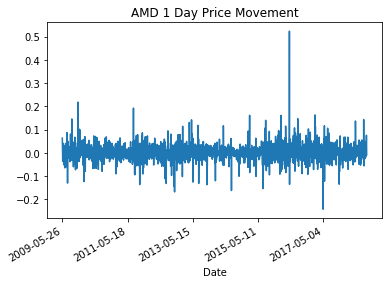

In [47]:
uni_data.plot(subplots=True)
plt.title('AMD 1 Day Price Movement')

In [48]:
uni_data = uni_data.values

In [49]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [50]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [51]:
univariate_past_history = 30
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [52]:
BATCH_SIZE = 32

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(TRAIN_SPLIT).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [53]:
amd_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])
amd_lstm_model.add(tf.keras.layers.Dropout(0.2))
amd_lstm_model.add(tf.keras.layers.Activation('linear'))

amd_lstm_model.compile(optimizer='adam', loss='mape')

In [78]:
amd_lstm_model.fit(train_univariate, epochs=10,
                      steps_per_epoch=500,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
500/500 [==============================] - 5s 9ms/step - loss: 104.9814 - val_loss: 100.9985
Epoch 2/10
500/500 [==============================] - 4s 9ms/step - loss: 98.5396 - val_loss: 99.7132
Epoch 3/10
500/500 [==============================] - 5s 9ms/step - loss: 98.2580 - val_loss: 99.2628
Epoch 4/10
500/500 [==============================] - 5s 9ms/step - loss: 97.8831 - val_loss: 98.8605
Epoch 5/10
500/500 [==============================] - 5s 9ms/step - loss: 97.9515 - val_loss: 99.0216
Epoch 6/10
500/500 [==============================] - 5s 10ms/step - loss: 97.8049 - val_loss: 99.3911
Epoch 7/10
500/500 [==============================] - 5s 10ms/step - loss: 97.7014 - val_loss: 99.4459
Epoch 8/10
500/500 [==============================] - 5s 10ms/step - loss: 97.6671 - val_loss: 99.5437
Epoch 9/10
500/500 [==============================] - 5s 10ms/step - loss: 97.3746 - val_loss: 99.0028
Epoch 10/10
500/500 [==============================] - 5s 10ms/step - loss: 

In [79]:
print(f'AMD data set MAPE: {model_mape(amd_lstm_model)}')

AMD data set MAPE: 99.4320571899414


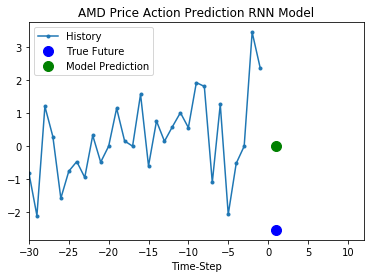

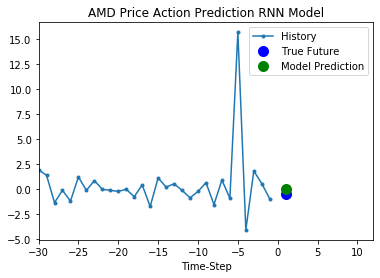

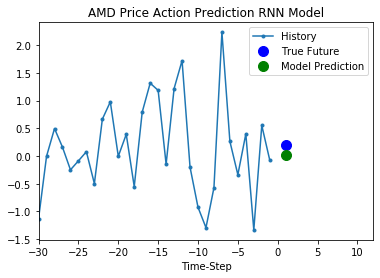

In [80]:
prediction_attempt(amd_lstm_model, 'AMD Price Action Prediction RNN Model', val_univariate)

In [149]:
x = amd[['Open', 'High','Low','Close', 'Volume']]
y = amd['Price Up Tomorrow']

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.75, shuffle=True)

In [216]:
(amd['Price Up Tomorrow']==1).describe()

count      2333
unique        2
top       False
freq       1184
Name: Price Up Tomorrow, dtype: object

In [217]:
scaler = StandardScaler() 
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [218]:
neural_model = MLPClassifier(solver='adam', alpha=0.0001, hidden_layer_sizes=(5,2))

In [219]:
neural_model.fit(x_train, y_train)
print(f'Model accuracy: {neural_model.score(x_train, y_train)}')

Model accuracy: 0.5145797598627787


In [220]:
neural_predict = neural_model.predict(x_test)

In [221]:
print(f'neural network model accuracy is: {neural_model.score(x_train, y_train)}')
print(f'neural network f1 score is: {f1_score(y_test, neural_predict)}')
print(f'neural network precision is: {precision_score(y_test, neural_predict)}')
print(f'neural network recall is: {recall_score(y_test, neural_predict)}')

neural network model accuracy is: 0.5145797598627787
neural network f1 score is: 0.4931034482758621
neural network precision is: 0.4847457627118644
neural network recall is: 0.5017543859649123


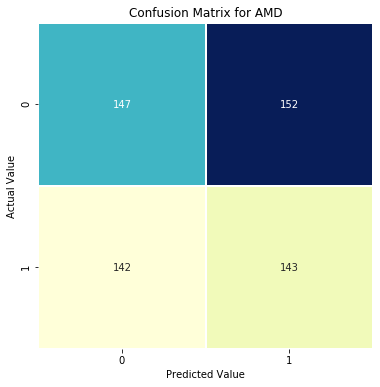

In [222]:
neural_matrix = confusion_matrix(y_test,neural_predict)

plt.subplots(figsize=(6, 6))
sns.heatmap(neural_matrix, annot=True, cbar=False, cmap='YlGnBu',linewidth=1,fmt="d")
plt.ylabel('Actual Value')
plt.xlabel('Predicted Value')
plt.title('Confusion Matrix for AMD');

Google Stock analysis

In [173]:
google = pd.read_csv('GOOGL.csv')

In [174]:
google.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2.335000e+03
mean,550.725409,555.136744,545.908515,550.662757,550.662757,3.764886e+06
std,278.136894,280.349025,275.855161,278.228484,278.228484,2.764696e+06
min,196.171173,199.524521,195.195190,196.946945,196.946945,5.206000e+05
25%,299.286773,301.759247,297.197204,299.144135,299.144135,1.734650e+06
50%,526.211182,532.780029,521.909973,527.767761,527.767761,3.250200e+06
75%,757.760010,763.745025,752.024994,758.524993,758.524993,4.891800e+06
max,1289.119995,1291.439941,1263.000000,1285.500000,1285.500000,2.961990e+07


In [175]:
google.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [176]:
google.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-05-22,198.528534,199.524521,196.196198,196.946945,196.946945,3433700
1,2009-05-26,196.171173,202.702698,195.195190,202.382385,202.382385,6202700
2,2009-05-27,203.023026,206.136139,202.607605,202.982986,202.982986,6062500
3,2009-05-28,204.544540,206.016022,202.507507,205.405411,205.405411,5332200
4,2009-05-29,206.261261,208.823822,205.555557,208.823822,208.823822,5291100


In [177]:
google['Percentage change in price'] = (google['Close']/google['Close'].shift(1))-1

In [178]:
google['Percentage change in price'].describe()

count    2334.000000
mean        0.000909
std         0.015005
min        -0.083775
25%        -0.006118
50%         0.000681
75%         0.008511
max         0.162584
Name: Percentage change in price, dtype: float64

In [179]:
google_auto_corr = pd.Series(google['Percentage change in price'])

In [180]:
google.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,Percentage change in price
0,2009-05-22,198.528534,199.524521,196.196198,196.946945,196.946945,3433700,NaN
1,2009-05-26,196.171173,202.702698,195.195190,202.382385,202.382385,6202700,0.027598
2,2009-05-27,203.023026,206.136139,202.607605,202.982986,202.982986,6062500,0.002968
3,2009-05-28,204.544540,206.016022,202.507507,205.405411,205.405411,5332200,0.011934
4,2009-05-29,206.261261,208.823822,205.555557,208.823822,208.823822,5291100,0.016642
5,2009-06-01,209.574570,215.015015,209.474472,213.493500,213.493500,6638100,0.022362
6,2009-06-02,213.338333,215.195190,211.911911,214.414413,214.414413,5241900,0.004314
7,2009-06-03,213.213211,216.446442,212.212219,216.041046,216.041046,7058500,0.007586
8,2009-06-04,217.867874,220.840836,217.467468,220.360367,220.360367,7268900,0.019993
9,2009-06-05,222.757751,223.893890,219.949951,222.382385,222.382385,7354200,0.009176


In [181]:
print(f'Google autocorrelation for percentage change in price at 1 day lag: {google_auto_corr.autocorr(lag=1)}')
print(f'Google autocorrelation for percentage change in price at 10 day lag: {google_auto_corr.autocorr(lag=10)}')
print(f'Google autocorrelation for percentage change in price at 30 day lag: {google_auto_corr.autocorr(lag=30)}')
print(f'Google autocorrelation for percentage change in price at 90 day lag: {google_auto_corr.autocorr(lag=90)}')

Google autocorrelation for percentage change in price at 1 day lag: 0.02977616713430228
Google autocorrelation for percentage change in price at 10 day lag: 0.011715200721515733
Google autocorrelation for percentage change in price at 30 day lag: -0.00723938611257335
Google autocorrelation for percentage change in price at 90 day lag: -0.016023588821673814


In [182]:
google.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2335 entries, 0 to 2334
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        2335 non-null   object 
 1   Open                        2335 non-null   float64
 2   High                        2335 non-null   float64
 3   Low                         2335 non-null   float64
 4   Close                       2335 non-null   float64
 5   Adj Close                   2335 non-null   float64
 6   Volume                      2335 non-null   int64  
 7   Percentage change in price  2334 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 146.1+ KB


In [183]:
google['1_day_close'] = google['Close'].shift(-1)

In [184]:
google['google_1_day_autocorr'] = google_auto_corr.autocorr(lag=1)
google['google_10_day_autocorr'] = google_auto_corr.autocorr(lag=10)
google['google_30_day_autocorr'] = google_auto_corr.autocorr(lag=30)
google['google_90_day_autocorr'] = google_auto_corr.autocorr(lag=90)

In [185]:
google['Price Up Tomorrow'] = np.where(google['Close'].shift(-1)>google['Close'], 1, 0) #Price up Tomorrow is True (1) if tomorrows 
#closing price is higher than todays. 

In [186]:
google.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,Percentage change in price,1_day_close,google_1_day_autocorr,google_10_day_autocorr,google_30_day_autocorr,google_90_day_autocorr,Price Up Tomorrow
0,2009-05-22,198.528534,199.524521,196.196198,196.946945,196.946945,3433700,NaN,202.382385,0.029776,0.011715,-0.007239,-0.016024,1
1,2009-05-26,196.171173,202.702698,195.195190,202.382385,202.382385,6202700,0.027598,202.982986,0.029776,0.011715,-0.007239,-0.016024,1
2,2009-05-27,203.023026,206.136139,202.607605,202.982986,202.982986,6062500,0.002968,205.405411,0.029776,0.011715,-0.007239,-0.016024,1
3,2009-05-28,204.544540,206.016022,202.507507,205.405411,205.405411,5332200,0.011934,208.823822,0.029776,0.011715,-0.007239,-0.016024,1
4,2009-05-29,206.261261,208.823822,205.555557,208.823822,208.823822,5291100,0.016642,213.493500,0.029776,0.011715,-0.007239,-0.016024,1
5,2009-06-01,209.574570,215.015015,209.474472,213.493500,213.493500,6638100,0.022362,214.414413,0.029776,0.011715,-0.007239,-0.016024,1
6,2009-06-02,213.338333,215.195190,211.911911,214.414413,214.414413,5241900,0.004314,216.041046,0.029776,0.011715,-0.007239,-0.016024,1
7,2009-06-03,213.213211,216.446442,212.212219,216.041046,216.041046,7058500,0.007586,220.360367,0.029776,0.011715,-0.007239,-0.016024,1
8,2009-06-04,217.867874,220.840836,217.467468,220.360367,220.360367,7268900,0.019993,222.382385,0.029776,0.011715,-0.007239,-0.016024,1
9,2009-06-05,222.757751,223.893890,219.949951,222.382385,222.382385,7354200,0.009176,219.604599,0.029776,0.011715,-0.007239,-0.016024,0


In [187]:
google.dropna(axis=0, inplace=True) #remove rows with null values from data set

In [188]:
google.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2333 entries, 1 to 2333
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        2333 non-null   object 
 1   Open                        2333 non-null   float64
 2   High                        2333 non-null   float64
 3   Low                         2333 non-null   float64
 4   Close                       2333 non-null   float64
 5   Adj Close                   2333 non-null   float64
 6   Volume                      2333 non-null   int64  
 7   Percentage change in price  2333 non-null   float64
 8   1_day_close                 2333 non-null   float64
 9   google_1_day_autocorr       2333 non-null   float64
 10  google_10_day_autocorr      2333 non-null   float64
 11  google_30_day_autocorr      2333 non-null   float64
 12  google_90_day_autocorr      2333 non-null   float64
 13  Price Up Tomorrow           2333 

In [189]:
google.head(10) #verification tags have been computed correctly

,Date,Open,High,Low,Close,Adj Close,Volume,Percentage change in price,1_day_close,google_1_day_autocorr,google_10_day_autocorr,google_30_day_autocorr,google_90_day_autocorr,Price Up Tomorrow
1,2009-05-26,196.171173,202.702698,195.195190,202.382385,202.382385,6202700,0.027598,202.982986,0.029776,0.011715,-0.007239,-0.016024,1
2,2009-05-27,203.023026,206.136139,202.607605,202.982986,202.982986,6062500,0.002968,205.405411,0.029776,0.011715,-0.007239,-0.016024,1
3,2009-05-28,204.544540,206.016022,202.507507,205.405411,205.405411,5332200,0.011934,208.823822,0.029776,0.011715,-0.007239,-0.016024,1
4,2009-05-29,206.261261,208.823822,205.555557,208.823822,208.823822,5291100,0.016642,213.493500,0.029776,0.011715,-0.007239,-0.016024,1
5,2009-06-01,209.574570,215.015015,209.474472,213.493500,213.493500,6638100,0.022362,214.414413,0.029776,0.011715,-0.007239,-0.016024,1
6,2009-06-02,213.338333,215.195190,211.911911,214.414413,214.414413,5241900,0.004314,216.041046,0.029776,0.011715,-0.007239,-0.016024,1
7,2009-06-03,213.213211,216.446442,212.212219,216.041046,216.041046,7058500,0.007586,220.360367,0.029776,0.011715,-0.007239,-0.016024,1
8,2009-06-04,217.867874,220.840836,217.467468,220.360367,220.360367,7268900,0.019993,222.382385,0.029776,0.011715,-0.007239,-0.016024,1
9,2009-06-05,222.757751,223.893890,219.949951,222.382385,222.382385,7354200,0.009176,219.604599,0.029776,0.011715,-0.007239,-0.016024,0
10,2009-06-08,219.969971,220.680679,217.277283,219.604599,219.604599,6191200,-0.012491,218.028030,0.029776,0.011715,-0.007239,-0.016024,0


In [190]:
TRAIN_SPLIT = 1684

In [191]:
tf.random.set_seed(13)

In [192]:
uni_data = google['Percentage change in price']
uni_data.index = google['Date']
uni_data.head()

Date
2009-05-26    0.027598
2009-05-27    0.002968
2009-05-28    0.011934
2009-05-29    0.016642
2009-06-01    0.022362
Name: Percentage change in price, dtype: float64

Text(0.5, 1.0, 'Google 1 Day Price Movement')

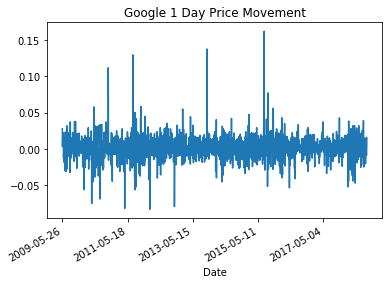

In [193]:
uni_data.plot(subplots=True)
plt.title('Google 1 Day Price Movement')

In [194]:
uni_data = uni_data.values

In [195]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [196]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [197]:
univariate_past_history = 30
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [198]:
BATCH_SIZE = 32


train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(TRAIN_SPLIT).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [199]:
google_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])
google_lstm_model.add(tf.keras.layers.Dropout(0.2))
google_lstm_model.add(tf.keras.layers.Activation('linear'))

google_lstm_model.compile(optimizer='adam', loss='mape')

In [200]:
google_lstm_model.fit(train_univariate, epochs=10,
                      steps_per_epoch=500,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
500/500 [==============================] - 4s 9ms/step - loss: 110.6274 - val_loss: 100.4667
Epoch 2/10
500/500 [==============================] - 4s 8ms/step - loss: 104.7459 - val_loss: 100.3614
Epoch 3/10
500/500 [==============================] - 4s 9ms/step - loss: 106.0939 - val_loss: 99.6661
Epoch 4/10
500/500 [==============================] - 5s 9ms/step - loss: 103.7951 - val_loss: 100.0609
Epoch 5/10
500/500 [==============================] - 5s 9ms/step - loss: 103.3003 - val_loss: 100.2661
Epoch 6/10
500/500 [==============================] - 5s 9ms/step - loss: 103.2934 - val_loss: 99.7032
Epoch 7/10
500/500 [==============================] - 5s 10ms/step - loss: 102.3232 - val_loss: 100.6764
Epoch 8/10
500/500 [==============================] - 5s 10ms/step - loss: 102.6933 - val_loss: 100.6438
Epoch 9/10
500/500 [==============================] - 5s 10ms/step - loss: 103.3962 - val_loss: 100.0536
Epoch 10/10
500/500 [==============================] - 6s 11ms/

In [201]:
print(f'Google data MAPE: {model_mape(google_lstm_model)}')

Google data MAPE: 100.15140914916992


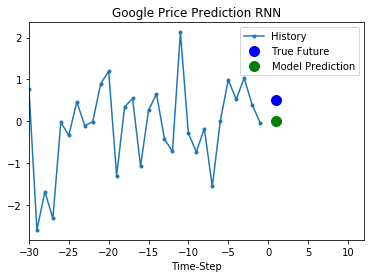

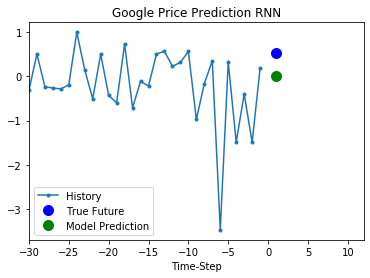

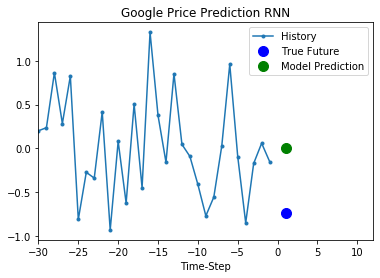

In [202]:
prediction_attempt(google_lstm_model, 'Google Price Prediction RNN', val_univariate)

In [203]:
x = google[['Open', 'High','Low','Close', 'Volume']]
y = google['Price Up Tomorrow']

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.75, shuffle=True)

In [204]:
(google['Price Up Tomorrow']==1).describe()

count     2333
unique       2
top       True
freq      1226
Name: Price Up Tomorrow, dtype: object

In [205]:
scaler = StandardScaler() 
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [206]:
neural_model = MLPClassifier(solver='adam', alpha=0.0001, hidden_layer_sizes=(5,2))

In [207]:
neural_model.fit(x_train, y_train)
print(f'Model accuracy: {neural_model.score(x_train, y_train)}')

Model accuracy: 0.505431675242996


In [208]:
neural_predict = neural_model.predict(x_test)

In [209]:
print(f'Google classification model accuracy is: {neural_model.score(x_train, y_train)}')
print(f'Google classification f1 score is: {f1_score(y_test, neural_predict)}')
print(f'Google classification precision is: {precision_score(y_test, neural_predict)}')
print(f'Google classification recall is: {recall_score(y_test, neural_predict)}')

Google classification model accuracy is: 0.505431675242996
Google classification f1 score is: 0.40480961923847697
Google classification precision is: 0.4975369458128079
Google classification recall is: 0.34121621621621623


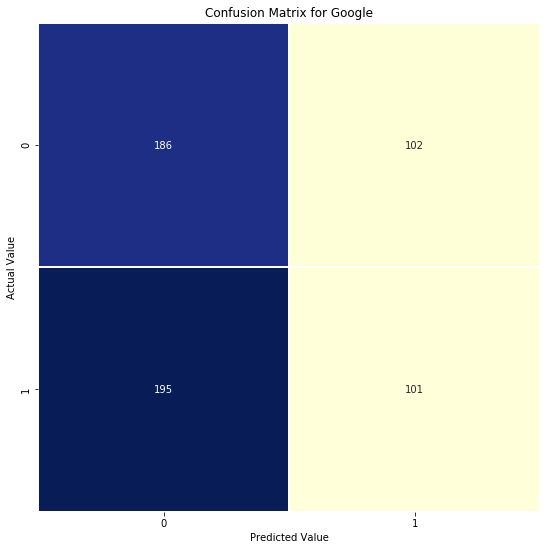

In [210]:
neural_matrix = confusion_matrix(y_test,neural_predict)

plt.subplots(figsize=(9, 9))
sns.heatmap(neural_matrix, annot=True, cbar=False, cmap='YlGnBu',linewidth=1,fmt="d")
plt.ylabel('Actual Value')
plt.xlabel('Predicted Value')
plt.title('Confusion Matrix for Google');

Conclusion: None of the models have any predicitve power. We have found no evidence against the EMH.